# Balls and Strikes Effects

## 6.2 Hitter’s Counts and Pitcher’s Counts

### 6.2.1 An example for a single pitcher

Analyzing Mike Mussina's career performance splits by count. The tOPS+ metric compares a player's OPS in each count situation to their overall OPS (100 = average, >100 = better than average, <100 = worse than average).

In [1]:
import pandas as pd
import numpy as np

balls = np.repeat([0, 1, 2, 3], 3)
strikes = np.tile([0, 1, 2], 4)

mussina = pd.DataFrame({
    'balls': balls,
    'strikes': strikes,
    'value': [
        100, 72, 30, 118, 82, 38,
        157, 114, 64, 207, 171, 122
    ]
})
mussina

,balls,strikes,value
0,0,0,100
1,0,1,72
2,0,2,30
3,1,0,118
4,1,1,82
5,1,2,38
6,2,0,157
7,2,1,114
8,2,2,64
9,3,0,207


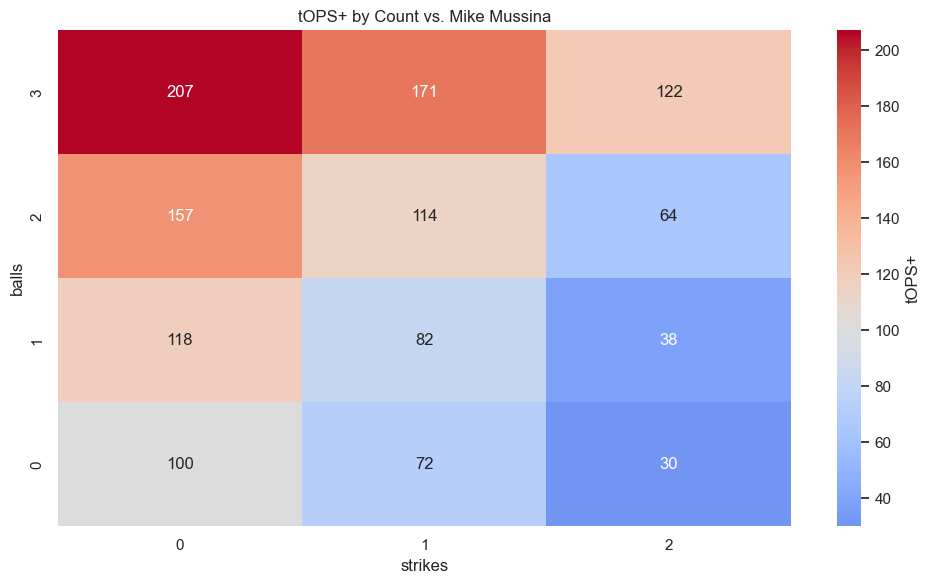

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style='darkgrid', palette='deep')

fig, ax = plt.subplots(figsize=(10, 6))

pivot_data = mussina.pivot(index='balls', columns='strikes', values='value')

sns.heatmap(
    pivot_data,
    annot=True,
    fmt='g',
    cmap='coolwarm',
    center=100,
    cbar_kws={'label': 'tOPS+'},
    ax=ax
)

ax.invert_yaxis()

ax.set_xlabel('strikes')
ax.set_ylabel('balls')
ax.set_title('tOPS+ by Count vs. Mike Mussina')

plt.tight_layout()
plt.show()


**Count Categories:**
- **Pitcher's counts** (0-2, 1-2, 0-1): Batters perform poorly (tOPS+ well below 100)
- **Hitter's counts** (3-0, 3-1, 2-0): Batters dominate (tOPS+ significantly above 100)
- **Neutral counts** (0-0, 1-1): Performance near average

The heatmap shows batters facing Mussina performed over 2x better in 3-0 counts (207) compared to 0-2 counts (30).

### 6.2.2 Pitch sequences from Retrosheet

Retrosheet encodes each pitch in a plate appearance as a character string. For example "FBSX" means:
- F = Foul ball
- B = Ball
- S = Called strike
- X = Ball in play

Need to clean and analyze sequences to determine which plate appearances passed through specific counts.

In [3]:
fields = pd.read_csv('../data/fields.csv')
headers = fields['Header'].str.lower().tolist()

retro2016 = pd.read_csv('../data/all2016.csv', names=headers, low_memory=False)

retro2016[['pitch_seq_tx']].head(10)

,pitch_seq_tx
0,BX
1,X
2,SFS
3,BCX
4,BSS*B1S
5,BBX
6,BCX
7,CX
8,BCCS
9,SBFX


#### String manipulation for pitch sequences

To analyze counts:
1. Remove non-pitch characters (ex: pickoff attempts, pitchouts, etc)
2. Count balls (B) and strikes (S, C, F, etc) to determine the count
3. Identify which plate appearances passed through specific counts

In [4]:
sequences = retro2016['pitch_seq_tx'].fillna('')

cleaned = sequences.str.replace(r'[.>123N+*]', '', regex=True)

example_df = pd.DataFrame({
    'original': sequences.head(10),
    'cleaned': cleaned.head(10),
    'length': cleaned.head(10).str.len()
})
example_df

,original,cleaned,length
0,BX,BX,2
1,X,X,1
2,SFS,SFS,3
3,BCX,BCX,3
4,BSS*B1S,BSSBS,5
5,BBX,BBX,3
6,BCX,BCX,3
7,CX,CX,2
8,BCCS,BCCS,4
9,SBFX,SBFX,4


#### 6.2.2.1 Functions for string manipulation

In [5]:
len("BBSBFFFX")

8

Using `str.contains()` and `np.where()` functions to search for patterns

In [6]:
sequences = pd.Series(["BBX", "C11BBC1S", "1X"])
sequences

0         BBX
1    C11BBC1S
2          1X
dtype: object

Finding and replacing indices with patterns

In [7]:
# Slightly different compared to R Book output as Python is 0 based index and R is 1 based
np.where(sequences.str.contains("1"))[0]

array([1, 2])

In [8]:
sequences.str.contains("1")

0    False
1     True
2     True
dtype: bool

In [9]:
sequences.str.contains("11")

0    False
1     True
2    False
dtype: bool

In [10]:
sequences.str.replace("1", "", regex=False)

0      BBX
1    CBBCS
2        X
dtype: object

#### 6.2.2.2 Finding plate appearances going through a given count

In [11]:
fields = pd.read_csv('../data/fields.csv')
headers = fields['Header'].str.lower().tolist()

retro2016 = pd.read_csv('../data/all2016.csv', names=headers, low_memory=False)

In [12]:
pbp2016 = retro2016.copy()
pbp2016['pseq'] = pbp2016['pitch_seq_tx'].str.replace(r'[.>123N+*]', '', regex=True)

In [13]:
# Detect 1-0 counts
pbp2016['c10'] = pbp2016['pseq'].str.match(r'^[BIPV]')

In [14]:
# Detect 0-1 counts
pbp2016['c01'] = pbp2016['pseq'].str.match(r'^[CFKLMOQRST]')

In [15]:
pbp2016[['pitch_seq_tx', 'c10', 'c01']].head(10)

,pitch_seq_tx,c10,c01
0,BX,True,False
1,X,False,False
2,SFS,False,True
3,BCX,True,False
4,BSS*B1S,True,False
5,BBX,True,False
6,BCX,True,False
7,CX,False,True
8,BCCS,True,False
9,SBFX,False,True


### 6.2.3 Expected run value by count

In [16]:
import sys
sys.path.append('../')
from src.retrosheet_utils import retrosheet_add_states, retrosheet_add_counts

In [17]:
pbp2016 = retrosheet_add_states(pbp2016)

In [18]:
# Load the 2016 run expectancy matrix created in Ch 5
erm_2016 = pd.read_pickle('../data/erm_2016.pkl')

pbp2016 = (pbp2016
    .merge(erm_2016[['bases', 'outs_ct', 'mean_run_value']], 
           on=['bases', 'outs_ct'], how='left')
    .rename(columns={'mean_run_value': 'rv_start'})
    .merge(erm_2016.rename(columns={'bases': 'new_bases', 'outs_ct': 'new_outs'})[
        ['new_bases', 'new_outs', 'mean_run_value']], 
           on=['new_bases', 'new_outs'], how='left')
    .rename(columns={'mean_run_value': 'rv_end'})
    .fillna({'rv_end': 0}) 
)

pbp2016['run_value'] = pbp2016['rv_end'] - pbp2016['rv_start'] + pbp2016['runs_scored']


In [19]:
pbp2016 = retrosheet_add_counts(pbp2016)

In [20]:
pbp2016[[
    'game_id', 'event_id', 'run_value', 'c00', 'c10', 'c20', 
    'c11', 'c01', 'c30', 'c21', 'c31', 'c02', 'c12', 'c22', 'c32'
]].head(5)

,game_id,event_id,run_value,c00,c10,c20,c11,c01,c30,c21,c31,c02,c12,c22,c32
0,ANA201604040,1,0.635008,True,True,False,False,False,False,False,False,False,False,False,False
1,ANA201604040,2,-0.196288,True,False,False,False,False,False,False,False,False,False,False,False
2,ANA201604040,3,-0.564935,True,False,False,False,True,False,False,False,True,False,False,False
3,ANA201604040,4,0.848252,True,True,False,True,False,False,False,False,False,False,False,False
4,ANA201604040,5,-0.220206,True,True,False,True,False,False,False,False,False,True,True,False


The pbp2016 data frame has all the necessary information to calculate the run values of the various balls/strikes counts, in the same way the value of a home run and of a single were calculated in Section 5.8.

In [21]:
(pbp2016[pbp2016['c10'] | pbp2016['c01']]
    .groupby(['c10', 'c01'])
    .agg(
        num_ab=('c10', 'size'),
        mean_run_value=('run_value', 'mean')
    )
    .reset_index()
)

,c10,c01,num_ab,mean_run_value
0,False,True,94108,-0.039441
1,True,False,76165,0.037064


The difference between a first pitch strike and a first pitch ball, as estimated with data from the 2016 season, is over 0.07 expected runs.

In [22]:
pbp_counts = pbp2016[[col for col in pbp2016.columns if col.startswith('c')] + ['run_value']]

In [23]:
pbp_counts_tidy = pbp_counts.melt(
    id_vars=['run_value'],
    var_name='count',
    value_name='passed_thru'
)

pbp_counts_tidy.sample(6)

,run_value,count,passed_thru
580248,-0.106208,c20,True
1332699,0.193404,c11,False
226772,0.113998,c01,False
1486496,-0.161695,c21,False
2278297,0.193404,c32,False
381241,-0.106208,c01,False


In [24]:
run_value_by_count = (pbp_counts_tidy[pbp_counts_tidy['passed_thru'] == True]
    .groupby('count')
    .agg(
        num_ab=('count', 'size'),
        value=('run_value', 'mean')
    )
    .reset_index()
)

In [25]:
run_value_by_count

,count,num_ab,value
0,c00,190715,0.001228
1,c01,94108,-0.039441
2,c02,38358,-0.094270
3,c10,76165,0.037064
4,c11,75227,-0.014829
5,c12,54205,-0.071311
6,c20,26298,0.091729
7,c21,38847,0.028210
8,c22,44254,-0.036794
9,c30,8594,0.189298


In [26]:
run_value_by_count['balls'] = run_value_by_count['count'].str[1]
run_value_by_count['strikes'] = run_value_by_count['count'].str[2]

run_value_by_count['balls'] = run_value_by_count['balls'].astype(int)
run_value_by_count['strikes'] = run_value_by_count['strikes'].astype(int)

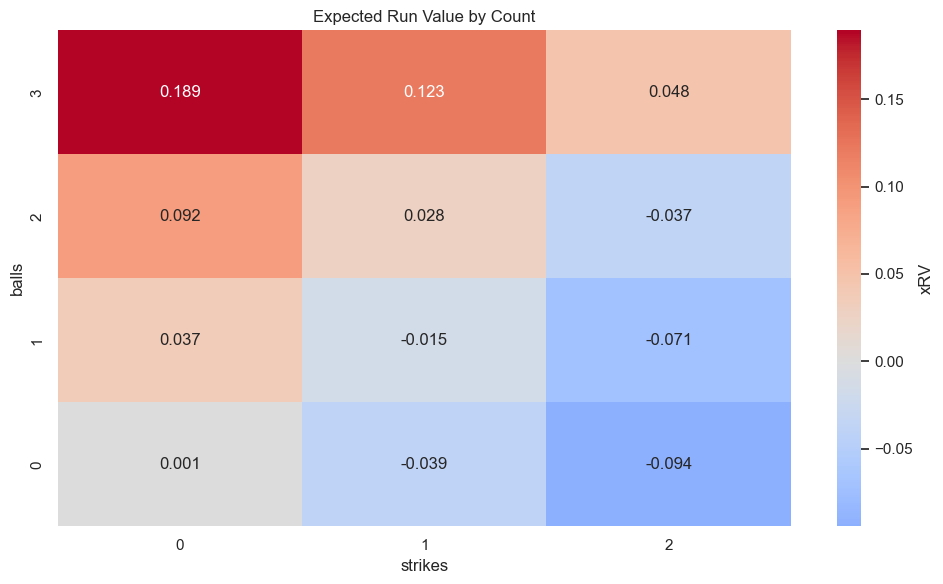

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

pivot_data = run_value_by_count.pivot(index='balls', columns='strikes', values='value')

fig, ax = plt.subplots(figsize=(10, 6))

sns.heatmap(
    pivot_data,
    annot=True,
    fmt='.3f',
    cmap='coolwarm',
    center=0,
    cbar_kws={'label': 'xRV'},
    ax=ax
)

ax.invert_yaxis()

ax.set_xlabel('strikes')
ax.set_ylabel('balls')
ax.set_title('Expected Run Value by Count')

plt.tight_layout()
plt.show()


Ball/strike counts can be roughly divided in the following four categories:
- Pitcher’s counts: 0-2, 1-2, 2-2, 0-1;
- Neutral counts: 0-0, 1-1;
- Modest hitter’s counts: 3-2, 2-1, 1-0;
- Hitter’s counts: 3-0, 3-1, 2-0.


### 6.2.4 The importance of the previous count

In [28]:
count22 = pbp2016[pbp2016['c22'] == True]

count22.agg(
    num_ab=('run_value', 'size'),
    mean_run_value=('run_value', 'mean')
).transpose()

,num_ab,mean_run_value
run_value,44254.0,-0.036794


In [29]:
count22 = count22.copy()
count22['after2'] = 'other'
count22.loc[count22['c20'] == True, 'after2'] = '2-0'
count22.loc[count22['c02'] == True, 'after2'] = '0-2'
count22.loc[count22['c11'] == True, 'after2'] = '1-1'

(count22.groupby('after2')
    .agg(
        num_ab=('after2', 'size'),
        mean_run_value=('run_value', 'mean')
    )
    .reset_index()
)

,after2,num_ab,mean_run_value
0,0-2,9837,-0.031081
1,1-1,28438,-0.037636
2,2-0,5979,-0.042190


The implication here is that plate appearances going through a 2-2 count after having started with two strikes are more favorable to the batter than those beginning with two balls.

In [30]:
count11 = pbp2016[pbp2016['c11'] == True].copy()

count11['after2'] = count11['c10'].apply(lambda x: '1-0' if x else '0-1')

(count11.groupby('after2')
    .agg(
        num_ab=('after2', 'size'),
        mean_run_value=('run_value', 'mean')
    )
    .reset_index()
)

,after2,num_ab,mean_run_value
0,0-1,38760,-0.012231
1,1-0,36467,-0.017591


After reaching a 1-1 count, a batter is expected to perform slightly worse if the first pitch was a ball than if it was a strike.

## 6.3 Behaviors by Count

In [31]:
# Using read_r function to load RData file to Python
import pyreadr

balls_strikes_count = pyreadr.read_r('../data/balls_strikes_count.RData')

print(balls_strikes_count.keys())

odict_keys(['cabrera', 'verlander', 'sanchez', 'umpires'])


1. Cabrera - contains four years of batting data for 2012 American League Triple Crown winner Miguel Cabrera.
2. Verlander - four years of pitching data for 2016 Cy Young Award and MVP recipient Justin Verlander.
3. Sanchez - this data frame is not used in Ch 6
4. Umpires - information about every pitch thrown in 2012 where the home plate umpire had to judge whether it crossed the strike zone.

### 6.3.1 Swinging tendencies by count

In [32]:
# Miguel Cabrera
cabrera = balls_strikes_count['cabrera']
cabrera.columns

Index(['season', 'gamedate', 'pitch_type', 'balls', 'strikes', 'speed', 'px',
       'pz', 'swung', 'hitx', 'hity', 'hit_outcome'],
      dtype='object')

#### 6.3.1.1 Propensity to swing by location

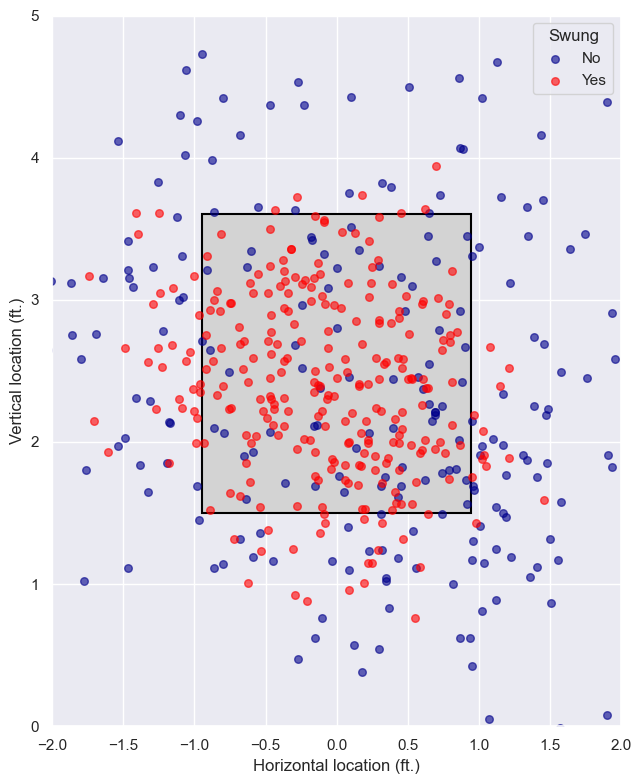

In [33]:
import matplotlib.pyplot as plt
from src.plotting_utils import add_strike_zone

cabrera_sample = cabrera.sample(500)

fig, ax = plt.subplots(figsize=(8, 8))

add_strike_zone(ax)

colors = {0: 'darkblue', 1: 'red'}
for swung_val, color in colors.items():
    subset = cabrera_sample[cabrera_sample['swung'] == swung_val]
    ax.scatter(subset['px'], subset['pz'], 
               c=color, label='Yes' if swung_val == 1 else 'No',
               alpha=0.6, s=30)

ax.set_aspect('equal')

ax.set_xlim(-2, 2)
ax.set_ylim(0, 5)
ax.set_xlabel('Horizontal location (ft.)')
ax.set_ylabel('Vertical location (ft.)')


ax.legend(title='Swung', loc='upper right')

plt.tight_layout()
plt.show()

Cabrera is less likely to swing at pitches further away from strike zone, but unable to determine preferred pitch locations to swing at based on 500 pitch samples

In [34]:
from pygam import LogisticGAM, s

miggy_gam = LogisticGAM(
    s(0, n_splines=10) + s(1, n_splines=10),
    lam=0.6
).fit(cabrera[['px', 'pz']], cabrera['swung'])

In [35]:
px_range = np.arange(-2, 2.1, 0.1)
pz_range = np.arange(0, 6.1, 0.1)

pred_area = pd.DataFrame({
    'px': np.repeat(px_range, len(pz_range)),
    'pz': np.tile(pz_range, len(px_range))
})

pred_area_fit = pred_area.copy()
pred_area_fit['fit'] = miggy_gam.predict_proba(pred_area[['px', 'pz']])

In [36]:
down_broadway = pred_area_fit[
    (np.abs(pred_area_fit['px'] - 0) < 0.01) & 
    (np.abs(pred_area_fit['pz'] - 2.5) < 0.01)
][['px', 'pz', 'fit']]

down_broadway['px'] = down_broadway['px'].round(1)
down_broadway['pz'] = down_broadway['pz'].round(1)

down_broadway

,px,pz,fit
1245,0.0,2.5,0.841105


In [37]:
ball_in_dirt = pred_area_fit[
    (np.abs(pred_area_fit['px'] - 0) < 0.01) & 
    (np.abs(pred_area_fit['pz'] - 0) < 0.01)
][['px', 'pz', 'fit']]

ball_in_dirt['px'] = ball_in_dirt['px'].round(1)
ball_in_dirt['pz'] = ball_in_dirt['pz'].round(1)

ball_in_dirt

,px,pz,fit
1220,0.0,0.0,0.098336


In [38]:
way_outside = pred_area_fit[
    (np.abs(pred_area_fit['px'] - 2) < 0.01) & 
    (np.abs(pred_area_fit['pz'] - 2.5) < 0.01)
][['px', 'pz', 'fit']]

way_outside['px'] = way_outside['px'].round(1)
way_outside['pz'] = way_outside['pz'].round(1)

way_outside

,px,pz,fit
2465,2.0,2.5,0.039772


A pitch right in the middle of the strike zone results in Cabrera to swing more than 80 percent of the time, while the ball in the dirt and the ball outside generate a swing at 15 percent and 8 percent rates.

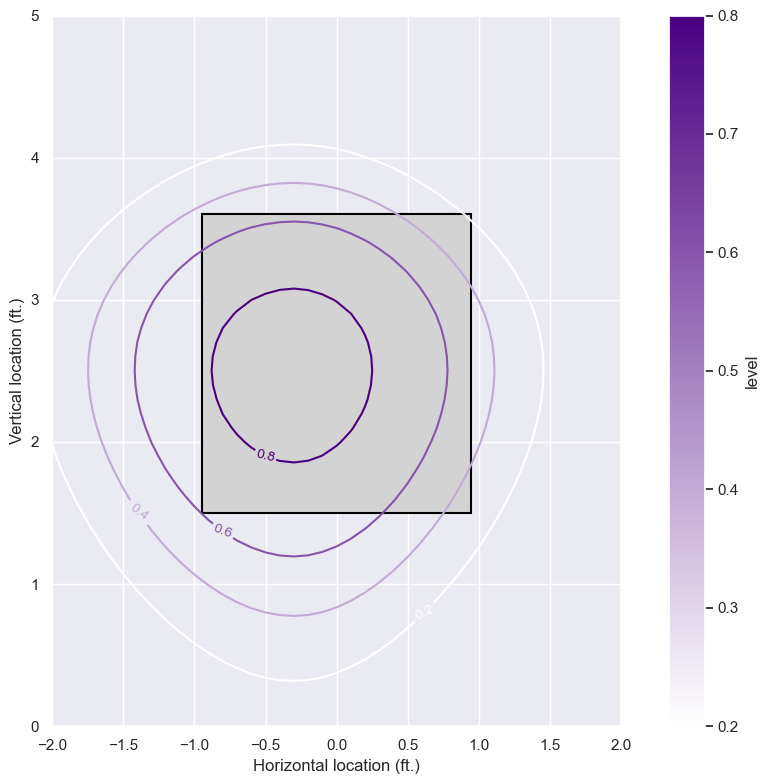

In [39]:
from matplotlib.colors import LinearSegmentedColormap
from src.plotting_utils import add_strike_zone

Z = pred_area_fit.pivot(index='pz', columns='px', values='fit').values
X, Y = np.meshgrid(px_range, pz_range)

fig, ax = plt.subplots(figsize=(10, 8))

add_strike_zone(ax)

cmap = LinearSegmentedColormap.from_list('white_to_blue', ['white', '#4B0082'])
contours = ax.contour(X, Y, Z, levels=[0.2, 0.4, 0.6, 0.8], cmap=cmap, linewidths=1.5)
ax.clabel(contours, inline=True, fontsize=10, fmt='%.1f')

sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0.2, vmax=0.8))
plt.colorbar(sm, ax=ax, label='level')

ax.set_xlabel('Horizontal location (ft.)')
ax.set_ylabel('Vertical location (ft.)')
ax.set_xlim(-2, 2)
ax.set_ylim(0, 5)
ax.set_aspect('equal')

plt.tight_layout()
plt.show()

The likelihood of a swing decreases the further the ball is delivered from the middle of the strike zone.

**Note:** Using LogisticGAM (`pygam` library) as Python alternative to R's `loess()` for smoothing swing probabilities.  Output differs slightly compared to R examples.

References on `pygam` library:
 - https://www.geeksforgeeks.org/artificial-intelligence/generalized-additive-model-in-python/
 - https://pygam.readthedocs.io/en/latest/

#### 6.3.1.2 Effect of the ball/strike count

In [40]:
counts = ["0-0", "0-2", "2-0"]

cabrera['count'] = cabrera['balls'].astype(str) + '-' + cabrera['strikes'].astype(str)

count_dfs = {
    count: cabrera[cabrera['count'] == count].copy()
    for count in counts
}

In [41]:
count_fits_dict = {}

for count in counts:
    gam = LogisticGAM(
        s(0, n_splines=10) + s(1, n_splines=10),
        lam=0.6
    ).fit(count_dfs[count][['px', 'pz']], count_dfs[count]['swung'])
    
    count_fits_dict[count] = pred_area.assign(
        fit=gam.predict_proba(pred_area[['px', 'pz']]),
        count=count
    )

count_fits = (pd.concat(count_fits_dict.values(), ignore_index=True)
    .assign(
        balls=lambda x: x['count'].str[0],
        strikes=lambda x: x['count'].str[2]
    )
)

count_fits.head()

,px,pz,fit,count,balls,strikes
0,-2.0,0.0,0.004940,0-0,0,0
1,-2.0,0.1,0.006134,0-0,0,0
2,-2.0,0.2,0.007588,0-0,0,0
3,-2.0,0.3,0.009347,0-0,0,0
4,-2.0,0.4,0.011457,0-0,0,0


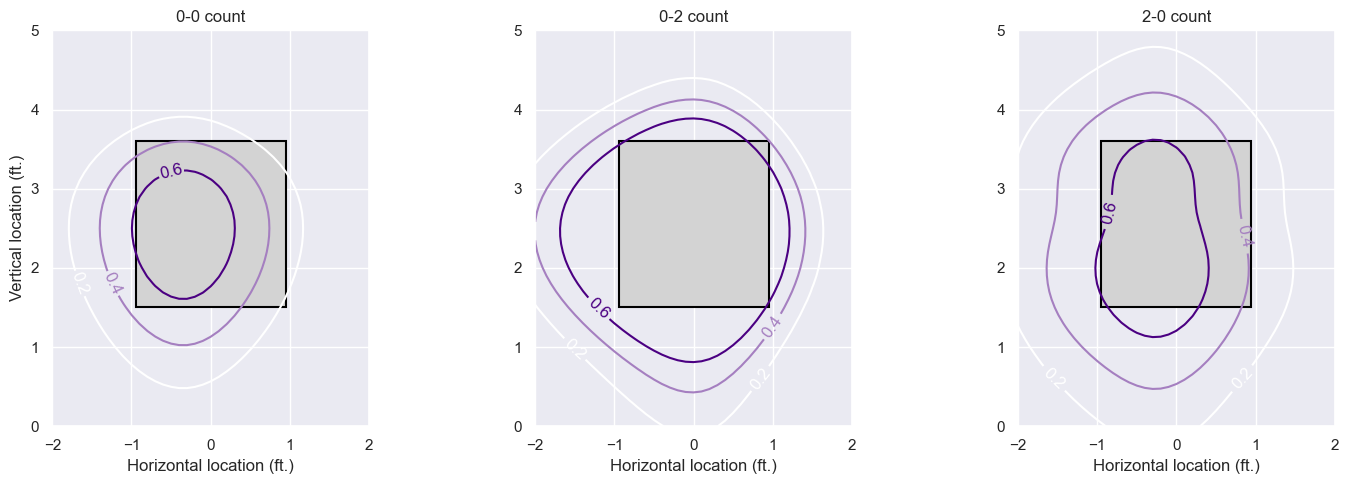

In [42]:
from matplotlib.colors import LinearSegmentedColormap
from src.plotting_utils import add_strike_zone

count_fits_filtered = count_fits[(count_fits['fit'] > 0.1) & (count_fits['fit'] < 0.7)]

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i, count in enumerate(counts):
    ax = axes[i]
    
    count_data = count_fits_filtered[count_fits_filtered['count'] == count]
    
    pivot_data = count_data.pivot(index='pz', columns='px', values='fit')
    
    px_vals = pivot_data.columns.values
    pz_vals = pivot_data.index.values
    X, Y = np.meshgrid(px_vals, pz_vals)
    Z = pivot_data.values
    
    add_strike_zone(ax)
    
    cmap = LinearSegmentedColormap.from_list('white_to_blue', ['white', '#4B0082'])
    contours = ax.contour(X, Y, Z, levels=[0.2, 0.4, 0.6], cmap=cmap)
    ax.clabel(contours, inline=True, fmt='%.1f')
    
    ax.set_title(count + " count")
    ax.set_xlabel('Horizontal location (ft.)')
    ax.set_ylabel('Vertical location (ft.)' if i == 0 else '')
    ax.set_xlim(-2, 2)
    ax.set_ylim(0, 5)
    ax.set_aspect('equal')

plt.tight_layout()
plt.show()


Cabrera expands his swing zone when behind 0-2 (his 40% contour line on 0-2 counts has an area comparable to his 20% contour line on 0-0 counts).  Low sample size in plot #3 does not provide much information to draw from

### 6.3.2 Pitch selection by count

In [43]:
verlander = balls_strikes_count['verlander']

(verlander
    .groupby('pitch_type', observed=True)
    .agg(N=('pitch_type', 'size'))
    .assign(pct=lambda x: x['N'] / len(verlander))
    .sort_values('pct', ascending=False)
    .reset_index()
)

,pitch_type,N,pct
0,FF,6756,0.441367
1,CU,2716,0.177435
2,CH,2550,0.166590
3,FT,2021,0.132031
4,SL,1264,0.082577


In [44]:
(verlander
    .groupby(['batter_hand', 'pitch_type'], observed=True)
    .agg(N=('pitch_type', 'size'))
    .reset_index()
    .pivot(index='pitch_type', columns='batter_hand', values='N')
    .fillna(0)
    .assign(
        L_pct=lambda x: x['L'] / x['L'].sum(),
        R_pct=lambda x: x['R'] / x['R'].sum()
    )
)

batter_hand,L,R,L_pct,R_pct
pitch_type,,,,
CH,2024,526,0.228288,0.081664
CU,1529,1187,0.172457,0.184288
FF,3832,2924,0.432213,0.453967
FT,1303,718,0.146966,0.111473
SL,178,1086,0.020077,0.168607


In [45]:
verlander_rhb = verlander[verlander['batter_hand'] == 'R']

(verlander_rhb
    .groupby(['balls', 'strikes', 'pitch_type'], observed=True)
    .agg(N=('pitch_type', 'size'))
    .reset_index()
    .pivot_table(
        index=['balls', 'strikes'],
        columns='pitch_type',
        values='N',
        fill_value=0,
        observed=True
    )
    .assign(num_pitches=lambda x: x.sum(axis=1))
    .apply(lambda row: row / row['num_pitches'], axis=1)
    .drop(columns='num_pitches')
)

pitch_type           CH        CU        FF        FT        SL
balls strikes                                                  
0     0        0.069212  0.114558  0.525656  0.156325  0.134248
      1        0.062353  0.242353  0.404706  0.101176  0.189412
      2        0.158215  0.281947  0.273834  0.062880  0.223124
1     0        0.049342  0.106908  0.523026  0.111842  0.208882
      1        0.080495  0.238390  0.397833  0.095975  0.187307
      2        0.143058  0.326788  0.277700  0.061711  0.190743
2     0        0.017442  0.017442  0.703488  0.145349  0.116279
      1        0.062284  0.079585  0.512111  0.141869  0.204152
      2        0.101664  0.293900  0.356747  0.086876  0.160813
3     0        0.083333  0.000000  0.812500  0.104167  0.000000
      1        0.019608  0.000000  0.784314  0.117647  0.078431
      2        0.042904  0.042904  0.693069  0.115512  0.105611

- When behind 2-0, Verlander uses his four-seamer seven times out of ten; the percentage goes up to 78% when trailing 3-1 and 81% on 3-0 counts.
- Throws the fastball less than 30 percent of the time on both 0-2 and 1-2 counts.

## 6.3.3 Umpires’ behavior by count

In [46]:
umpires = balls_strikes_count['umpires']

umpires.sample(20)

,season,umpire,batter_hand,pitch_type,balls,strikes,px,pz,called_strike
301793,2012,Kerwin Danley,R,FT,3,2,1.38,2.19,0
371012,2012,Ed Hickox,R,CU,1,0,0.91,2.20,1
167937,2012,Rob Drake,R,FT,1,0,-1.08,1.65,0
113229,2012,Mike Everitt,L,SL,0,0,-0.49,2.78,1
164481,2012,Wally Bell,L,SL,2,2,-1.49,1.82,0
189186,2012,Mike Estabrook,R,CU,2,1,-0.43,1.11,0
338955,2012,Eric Cooper,R,CU,0,0,-0.20,1.46,0
72410,2012,Vic Carapazza,R,CH,1,1,2.01,2.92,0
58448,2012,Tony Randazzo,L,FS,2,2,-0.75,0.79,0
274993,2012,Laz Diaz,R,SL,0,0,0.97,1.59,0


In [47]:
umpires_rhb = umpires[
    (umpires['batter_hand'] == 'R') &
    (
        ((umpires['balls'] == 0) & (umpires['strikes'] == 0)) |
        ((umpires['balls'] == 3) & (umpires['strikes'] == 0)) |
        ((umpires['balls'] == 0) & (umpires['strikes'] == 2))
    )
].copy()

In [48]:
umpires_rhb['count'] = (umpires_rhb['balls'].astype(str) + '-' + 
                        umpires_rhb['strikes'].astype(str))

counts = umpires_rhb['count'].unique()

count_dfs = {
    count: umpires_rhb[umpires_rhb['count'] == count].copy()
    for count in counts
}

ump_count_fits_dict = {}

for count in counts:
    sample_data = count_dfs[count].sample(min(3000, len(count_dfs[count])), random_state=42)
    
    gam = LogisticGAM(
        s(0, n_splines=10) + s(1, n_splines=10),
        lam=0.6
    ).fit(sample_data[['px', 'pz']], sample_data['called_strike'])
    
    ump_count_fits_dict[count] = pred_area.assign(
        fit=gam.predict_proba(pred_area[['px', 'pz']]),
        count=count
    )

ump_count_fits = (pd.concat(ump_count_fits_dict.values(), ignore_index=True)
    .assign(
        balls=lambda x: x['count'].str[0],
        strikes=lambda x: x['count'].str[2]
    )
)

ump_count_fits.head()

,px,pz,fit,count,balls,strikes
0,-2.0,0.0,9.912353e-12,0-0,0,0
1,-2.0,0.1,2.808515e-11,0-0,0,0
2,-2.0,0.2,7.956233e-11,0-0,0,0
3,-2.0,0.3,2.253515e-10,0-0,0,0
4,-2.0,0.4,6.381489e-10,0-0,0,0


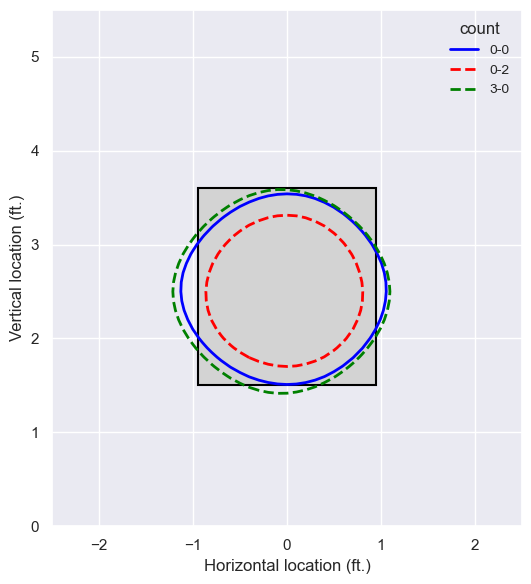

In [49]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.lines import Line2D
from src.plotting_utils import add_strike_zone

target_counts = ['0-0', '0-2', '3-0']

count_styles = {
    '0-0': {'color': 'blue', 'linestyle': '-', 'label': '0-0'},
    '0-2': {'color': 'red', 'linestyle': '--', 'label': '0-2'},
    '3-0': {'color': 'green', 'linestyle': '--', 'label': '3-0'}
}

fig, ax = plt.subplots(figsize=(8, 6))

add_strike_zone(ax)

for count in target_counts:
    count_data = ump_count_fits[ump_count_fits['count'] == count]
    
    pivot_data = count_data.pivot(index='pz', columns='px', values='fit')
    
    px_vals = pivot_data.columns.values
    pz_vals = pivot_data.index.values
    X, Y = np.meshgrid(px_vals, pz_vals)
    Z = pivot_data.values
    
    style = count_styles[count]
    contour = ax.contour(
        X, Y, Z, 
        levels=[0.5],
        colors=[style['color']], 
        linestyles=[style['linestyle']],
        linewidths=2,
        zorder=2
    )

legend_elements = [
    Line2D([0], [0], color=count_styles[c]['color'], 
           linestyle=count_styles[c]['linestyle'], 
           linewidth=2, label=c) 
    for c in target_counts
]
ax.legend(handles=legend_elements, title='count', loc='upper right', 
          frameon=False, fontsize=10)

ax.set_xlabel('Horizontal location (ft.)')
ax.set_ylabel('Vertical location (ft.)')
ax.set_xlim(-2.5, 2.5)
ax.set_ylim(0, 5.5)

ax.set_aspect('equal')

plt.tight_layout()
plt.show()

Umpire’s strike zone shrinks considerably in a 0-2 pitch count, and slightly expanded in a 3-0 count. 